# 文件输入输出

## 点云数据

In [19]:
import open3d as o3d
import numpy as np

In [2]:
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\BunnyMesh.ply')  # 使用o3d.io.read_point_cloud读取点云文件
print(pcd)
o3d.io.write_point_cloud(r"G:\open3d\data\copy_of_BunnyMesh.pcd", pcd) # 使用o3d.io.write_point_cloud保存点云文件

PointCloud with 35947 points.


True

保存点云时支持(.xyz) , (.ply) , (.pcd)等格式

## 网格数据

In [2]:
mesh = o3d.io.read_triangle_mesh(r'G:\open3d\data\KnotMesh.ply') # 使用o3d.io.read_triangle_mesh读取网格数据
print(mesh)
o3d.io.write_triangle_mesh(r"G:\open3d\data\copy_of_knot.ply", mesh) # 使用o3d.io.write_triangle_mesh保存网格数据

TriangleMesh with 1440 points and 2880 triangles.


True

保存网格数据支持(.ply), (.obj), (.stl)等格式

## 图像数据

In [3]:
img = o3d.io.read_image(r'G:\open3d\data\JuneauImage.jpg') #使用o3d.io.read_image读取图像数据
print(img)
o3d.io.write_image(r'G:\open3d\data\copy_of_JuneauImage.png', img) # 使用o3d.io.write_image保存图像数据

Image of size 800x489, with 3 channels.
Use numpy.asarray to access buffer data.


True

保存图像数据支持png和jpg格式

# 点云去噪

通常获取到的点云会有噪声，因此需要一定的手段将这些噪声去除。

## 加载数据并下采样

In [4]:
pcd = o3d.io.read_point_cloud(r'G:\open3d\data\fragment.pcd') # 读取数据

voxel_down_pcd = pcd.voxel_down_sample(voxel_size=0.02) # 下采样

o3d.visualization.draw_geometries([voxel_down_pcd]) # 可视化

可视化结果如图  
  
  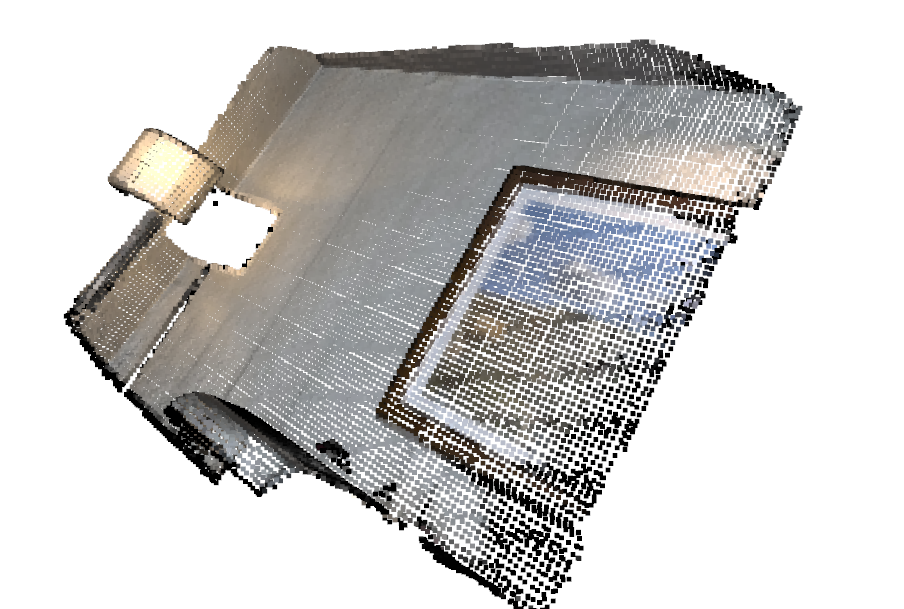

## 定义可视化函数

定义一个函数以便将噪声点染成红色

In [5]:
def display_inlier_outlier(cloud, ind):

    '''
    cloud:输入点云
    ind:索引
    '''

    # 根据索引分别选择噪声点和非噪声点
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("噪声点(红色)和非噪声点(灰色): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])

## 统计滤波

统计滤波移除与点云的平均值相比离相邻点更远的点，具体过程可参考 https://blog.csdn.net/u012901740/article/details/144028539

该方法需要两个参数nb_neighbors和std_ratio  
nb_neighbors表示需要多少个邻近点来计算到选定点的平均距离  
std_ratio设定点云平均距离的均方差以确定阈值水平，数字越小，可能会移除更多的噪声点

In [6]:
# 使用remove_statistical_outlier函数进行统计滤波
_, ind = voxel_down_pcd.remove_statistical_outlier(nb_neighbors=20,
                                                    std_ratio=2.0)
display_inlier_outlier(voxel_down_pcd, ind)

噪声点(红色)和非噪声点(灰色): 


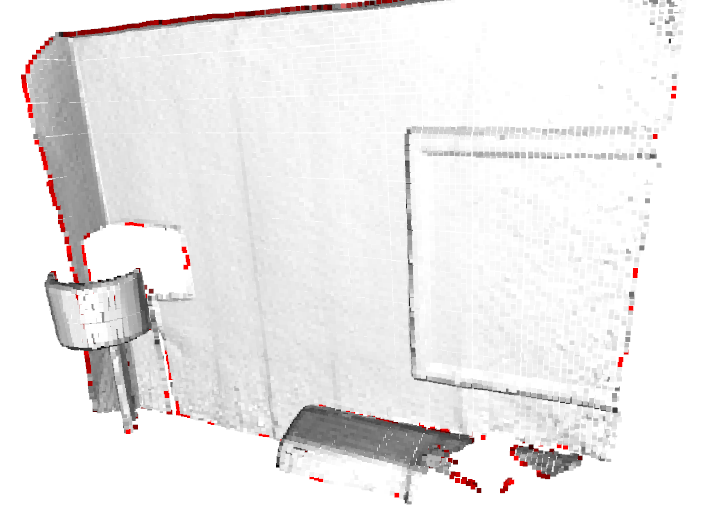

## 半径滤波

半径滤波的原理为：如果一个选定点在半径为r的球体内，其邻近点个数少于n，那么将该选定点移除。有两个参数需要设置。  
nb_points：邻近点个数，如果小于该数值则判定为噪声点  
radius：球体半径

In [7]:
# 使用remove_radius_outlier函数进行半径滤波
_, ind = voxel_down_pcd.remove_radius_outlier(nb_points=16, radius=0.05)
display_inlier_outlier(voxel_down_pcd, ind)

噪声点(红色)和非噪声点(灰色): 


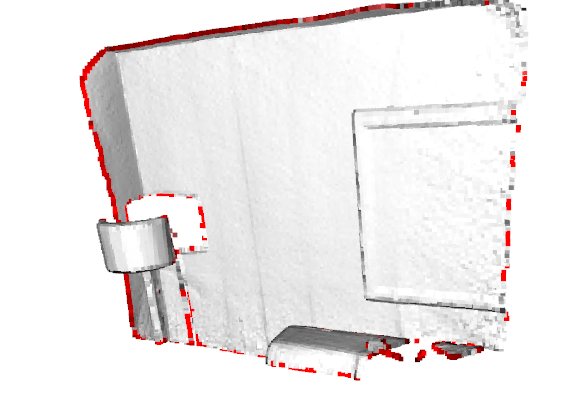

# 体素化

点云和三角网格是不规则的几何类型，而体素网格是一种规则的几何类型。open3d提供了一个类VoxelGrid以处理体素网格。  
tips:目前一部分点云深度学习是基于体素进行的，因此需要好好学习一下。

## 从三角网格创建体素

使用函数create_from_triangle_mesh可以从三角网格中创建体素，其中一个参数voxel_size定义了体素的分辨率

In [10]:
mesh = o3d.io.read_triangle_mesh(r'G:\open3d\data\BunnyMesh.ply')

# 对三角网格进行缩放
mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()),
           center=mesh.get_center())

o3d.visualization.draw_geometries([mesh])

# 使用VoxelGrid.create_from_triangle_mesh进行体素化
voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh,
                                                              voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])

[Open3D WARNING] [ViewControl] SetViewPoint() failed because window height and width are not set.


三角网格可视化效果  
  
  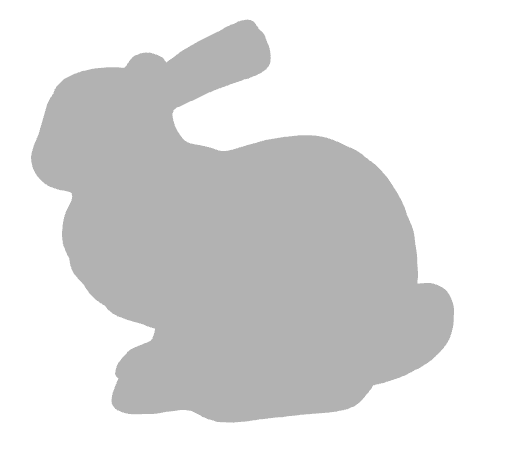

体素化效果  
  
  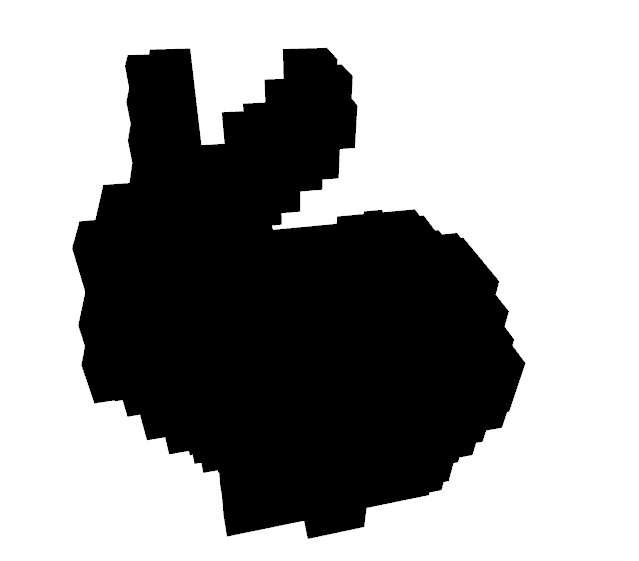

## 从点云中创建体素网格

使用create_from_point_cloud函数可以从点云中创建体素，参数voxel_size定义体素网格的分辨率。  
默认情况下，体素的颜色是体素内所有点的平均值。参数pooling_mode可以更改以通过点的平均值、最小值、最大值或总和值来确定颜色，例如使用o3d.geometry.VoxelGrid.VoxelPoolingMode.MIN

In [15]:
mesh = o3d.io.read_point_cloud(r'G:\open3d\data\ArmadilloMesh.ply')

# 进行随机下采样，采样比例为0.5
pcd = mesh.random_down_sample(0.5)

# 进行缩放
pcd.scale(1 / np.max(pcd.get_max_bound() - pcd.get_min_bound()),
          center=pcd.get_center())

# 给点云随机着色
N = len(pcd.points)
pcd.colors = o3d.utility.Vector3dVector(np.random.uniform(0, 1, size=(N, 3)))

o3d.visualization.draw_geometries([pcd])

# 使用VoxelGrid.create_from_point_cloud进行体素化，体素网格大小为0.05
voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(pcd,
                                                            voxel_size=0.05)
o3d.visualization.draw_geometries([voxel_grid])

点云可视化结果  
  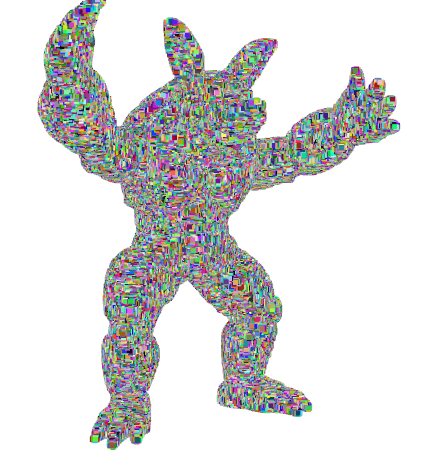

体素化结果  
  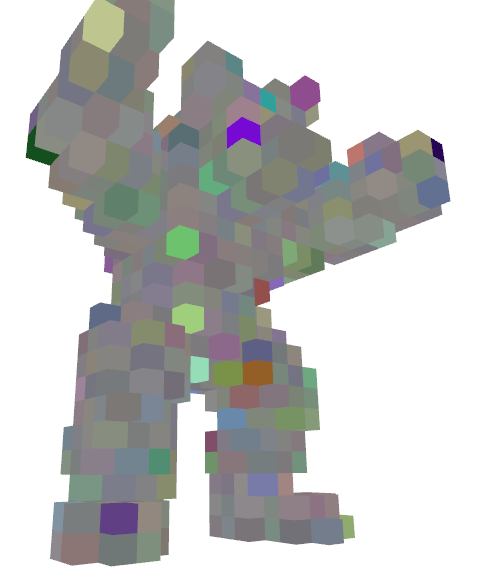


## 检查点是否在体素网格内

可以使用check_if_included检查点云是否在体素内，以(n*3)的数组作为输入，返回True或者False

In [21]:
queries = np.asarray(pcd.points)
output = voxel_grid.check_if_included(o3d.utility.Vector3dVector(queries))
print(output[40:50])

[True, True, True, True, True, True, True, True, True, True]
